In [2]:
import os
import cv2
import warnings
from cvzone.PoseModule import PoseDetector
from natsort import natsorted
import subprocess
import random
import matplotlib.pyplot as plt
import pickle
warnings.filterwarnings("ignore")

os.environ["OPENCV_VIDEOIO_PRIORITY_MSMF"] = "0"
os.environ["QT_QPA_PLATFORM"] = "offscreen"
os.chdir('..')



class PoseProcessor:
    '''
    Class to process a video and detect poses using Mediapipe PoseDetector, OpenCV and cvzone.

    Args:
        video_name (str): Name of the video file (without extension) to process.
        output_dir (str): Directory to save the processed frames. Default is "frames/posemodule".
        target_angle (int): Target angle for the arm. Default is 50.
        offset (int): Offset for angle checking. Default is 10.

    Methods:
        _setup_dirs(): Creates the output directory if it doesn't exist.
        _setup_video(): Initializes the video capture object.
        _setup_pose_detector(): Initializes the PoseDetector object.
        process_video(): Processes the video frame by frame, detecting poses and saving frames.

    Returns:
        Images with detected poses and angles are saved in the specified output directory.
    '''

    def __init__(self, video_name, output_dir="frames/posemodule", target_angle=50, offset=10):
        
        self.video_name = video_name
        self.video_path = f"data/{video_name}.mp4"
        self.output_path = os.path.join(output_dir, video_name)
        self.frame_count = 0
        self.target_angle = target_angle
        self.offset = offset

        self._setup_dirs()
        self._setup_video()
        self._setup_pose_detector()


    def _setup_dirs(self):
        os.makedirs(self.output_path, exist_ok=True)


    def _setup_video(self):
        self.cap = cv2.VideoCapture(self.video_path)
        if not self.cap.isOpened():
            raise FileNotFoundError(f"Cannot open video file: {self.video_path}")


    def _setup_pose_detector(self):
        self.detector = PoseDetector(
            staticMode=False,
            modelComplexity=1,
            smoothLandmarks=True,
            enableSegmentation=False,
            smoothSegmentation=True,
            detectionCon=0.5,
            trackCon=0.5
        )

    def process_video(self):
        while True:
            success, img = self.cap.read()
            if not success or img is None:
                print("Video ended. Processing complete.")
                break

            img = self.detector.findPose(img)
            lmList, bboxInfo = self.detector.findPosition(img, draw=True, bboxWithHands=False)

            if lmList:
                center = bboxInfo["center"]
                cv2.circle(img, center, 5, (255, 0, 255), cv2.FILLED)

                length, img, _ = self.detector.findDistance(
                    lmList[11][0:2],
                    lmList[15][0:2],
                    img=img,
                    color=(255, 0, 0),
                    scale=10
                )

                angle, img = self.detector.findAngle(
                    lmList[11][0:2],
                    lmList[13][0:2],
                    lmList[15][0:2],
                    img=img,
                    color=(0, 0, 255),
                    scale=10
                )

                isClose = self.detector.angleCheck(
                    myAngle=angle,
                    targetAngle=self.target_angle,
                    offset=self.offset
                )

                print(f"Frame {self.frame_count}: Angle ~{self.target_angle}°? {isClose}")

            out_file = os.path.join(self.output_path, f"frame_{self.frame_count:04}.jpg")
            cv2.imwrite(out_file, img)
            self.frame_count += 1

            cv2.waitKey(1)

        self.cap.release()
        cv2.destroyAllWindows()
        return self.output_path



class VideoCreator:
    '''
    Class to create a video from a series of image frames.

    Args:
        frame_dir (str): Directory containing the image frames.
        output_path (str): Path to save the output video. Default is "output/video_output.mp4".
        fps (int): Frames per second for the output video. Default is 30.

    Methods:
        _load_frames(): Loads image frames from the specified directory.
        _get_frame_size(): Gets the size of the first frame to set video dimensions.
        create_video(): Creates a video from the loaded frames and saves it to the specified output path.

    Returns:
        A video file created from the image frames is saved to the specified output path.
    '''

    def __init__(self, frame_dir, output_path="output/output_video.mp4", fps=30):
        self.frame_dir = frame_dir
        self.output_path = output_path
        self.fps = fps
        self.frames = self._load_frames()

        if not self.frames:
            raise ValueError(f"No frames found in directory: {frame_dir}")

        self.frame_size = self._get_frame_size(self.frames[0])
        self.fourcc = self._choose_fourcc()


    def _load_frames(self):
        valid_exts = ('.jpg', '.jpeg', '.png')
        return natsorted([f for f in os.listdir(self.frame_dir) if f.lower().endswith(valid_exts)])


    def _get_frame_size(self, sample_file):
        path = os.path.join(self.frame_dir, sample_file)
        img = cv2.imread(path)
        if img is None:
            raise ValueError(f"Can't read sample frame: {sample_file}")
        return (img.shape[1], img.shape[0])


    def _choose_fourcc(self):
        ext = os.path.splitext(self.output_path)[-1].lower()
        if ext == ".avi":
            return cv2.VideoWriter_fourcc(*"XVID")
        else:  # .mp4 or others
            return cv2.VideoWriter_fourcc(*"mp4v")


    def create_video(self):
        os.makedirs(os.path.dirname(self.output_path), exist_ok=True)
        writer = cv2.VideoWriter(self.output_path, self.fourcc, self.fps, self.frame_size)

        for f in self.frames:
            img = cv2.imread(os.path.join(self.frame_dir, f))
            if img is None:
                print(f"Skipping unreadable frame: {f}")
                continue
            if (img.shape[1], img.shape[0]) != self.frame_size:
                img = cv2.resize(img, self.frame_size)
            writer.write(img)

        writer.release()
        return self.output_path





def convert_to_modern_mp4(input_path, output_path):
    cmd = [
        "ffmpeg",
        "-y",  # Overwrite output files without asking
        "-i", input_path,
        "-c:v", "libx264",
        "-preset", "fast",
        "-crf", "23",
        "-c:a", "aac",
        "-b:a", "128k",
        output_path
    ]
    subprocess.run(cmd, check=True)
    print(f"Video successfully saved to: {output_path}")
    os.remove(input_path)

# Example 1

In [3]:
video_name = "demo1"
processor = PoseProcessor(video_name)
frame_dir = processor.process_video()

I0000 00:00:1744562093.232065  371141 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1744562093.244858  396037 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.2), renderer: RENOIR (renoir, LLVM 15.0.7, DRM 3.57, 6.8.0-57-generic)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1744562093.353209  396016 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744562093.412030  396019 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744562093.437749  396017 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


Frame 0: Angle ~50°? True
Frame 1: Angle ~50°? False
Frame 2: Angle ~50°? False
Frame 3: Angle ~50°? False
Frame 4: Angle ~50°? False
Frame 5: Angle ~50°? False
Frame 6: Angle ~50°? False
Frame 7: Angle ~50°? False
Frame 8: Angle ~50°? False
Frame 9: Angle ~50°? False
Frame 10: Angle ~50°? False
Frame 11: Angle ~50°? False
Frame 12: Angle ~50°? False
Frame 13: Angle ~50°? False
Frame 14: Angle ~50°? False
Frame 15: Angle ~50°? False
Frame 16: Angle ~50°? False
Frame 17: Angle ~50°? False
Frame 18: Angle ~50°? False
Frame 19: Angle ~50°? False
Frame 20: Angle ~50°? False
Frame 21: Angle ~50°? False
Frame 22: Angle ~50°? False
Frame 23: Angle ~50°? False
Frame 24: Angle ~50°? False
Frame 25: Angle ~50°? False
Frame 26: Angle ~50°? False
Frame 27: Angle ~50°? False
Frame 28: Angle ~50°? False
Frame 29: Angle ~50°? False
Frame 30: Angle ~50°? False
Frame 31: Angle ~50°? False
Frame 32: Angle ~50°? False
Frame 33: Angle ~50°? False
Frame 34: Angle ~50°? False
Frame 35: Angle ~50°? False
Fra

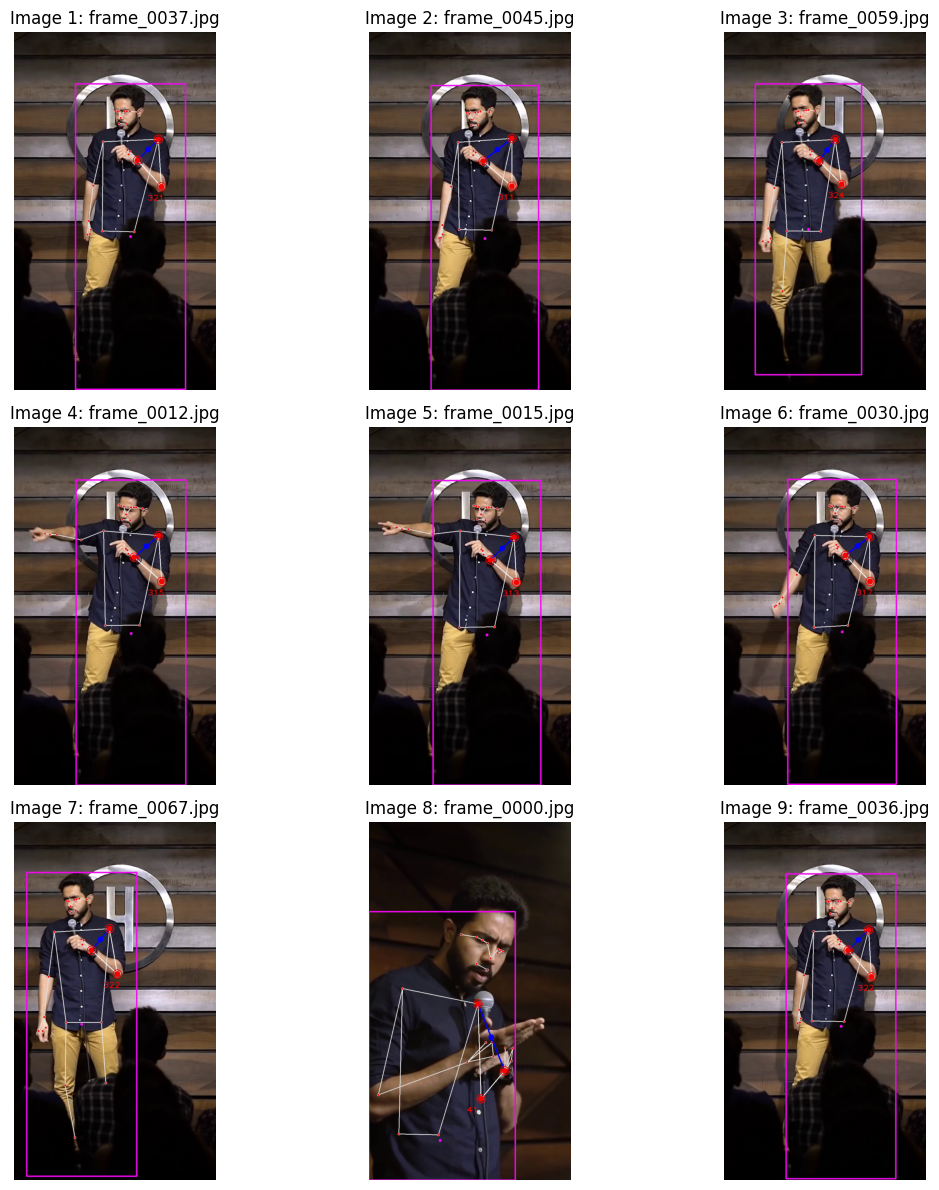

In [4]:
# Filter jpg_files to include only the first 100 images
jpg_files = [f for f in os.listdir(frame_dir) if f.lower().endswith('.jpg') and int(f.split('_')[1].split('.')[0]) < 100]

# Randomly sample 9 images from the filtered list
jpg_files = random.sample(jpg_files, 9)

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

for i, img_file in enumerate(jpg_files):
    img_path = os.path.join(frame_dir, img_file)
    try:
        img = plt.imread(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f"Image {i+1}: {img_file}")
        axes[i].axis('off')  # Hide axes
    except Exception as e:
        print(f"Error loading {img_file}: {e}")
        axes[i].text(0.5, 0.5, f"Error loading\n{img_file}", 
                    horizontalalignment='center',
                    verticalalignment='center')
        axes[i].axis('off')

for j in range(len(jpg_files), 9):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [5]:
frame_dir = f"frames/posemodule/{video_name}/"
vc = VideoCreator(frame_dir, output_path=f"output/{video_name}_output.avi", fps=30)
output_mpeg4_file = vc.create_video()
output_mp4_file = convert_to_modern_mp4(output_mpeg4_file, f"output/{video_name}_output_posemodule.mp4")

print(f"Output video saved at: {output_mp4_file}")

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Video successfully saved to: output/demo1_output_posemodule.mp4
Output video saved at: None


frame=  165 fps=0.0 q=-1.0 Lsize=     978kB time=00:00:05.40 bitrate=1483.4kbits/s speed=6.54x    
video:975kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.256021%
[libx264 @ 0x5aea416488c0] frame I:3     Avg QP:15.81  size: 23169
[libx264 @ 0x5aea416488c0] frame P:77    Avg QP:21.60  size:  8734
[libx264 @ 0x5aea416488c0] frame B:85    Avg QP:23.33  size:  3012
[libx264 @ 0x5aea416488c0] consecutive B-frames: 27.9%  8.5%  5.5% 58.2%
[libx264 @ 0x5aea416488c0] mb I  I16..4: 49.7% 43.1%  7.2%
[libx264 @ 0x5aea416488c0] mb P  I16..4:  3.3%  6.6%  1.0%  P16..4: 18.3%  6.0%  3.2%  0.0%  0.0%    skip:61.6%
[libx264 @ 0x5aea416488c0] mb B  I16..4:  1.1%  1.9%  0.2%  B16..8: 13.7%  3.2%  0.4%  direct: 1.9%  skip:77.6%  L0:53.0% L1:41.5% BI: 5.5%
[libx264 @ 0x5aea416488c0] 8x8 transform intra:56.4% inter:70.1%
[libx264 @ 0x5aea416488c0] coded y,uvDC,uvAC intra: 35.6% 43.9% 10.5% inter: 5.0% 6.6% 1.6%
[libx264 @ 0x5aea416488c0] i16 v,h,dc,p: 54% 34%  7%  4%
[li

# Example 2

In [6]:
video_name = "demo2"
processor = PoseProcessor(video_name)
frame_dir = processor.process_video()

I0000 00:00:1744562103.069147  371141 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1744562103.070096  396192 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.2), renderer: RENOIR (renoir, LLVM 15.0.7, DRM 3.57, 6.8.0-57-generic)
W0000 00:00:1744562103.135656  396180 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744562103.177556  396186 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Frame 9: Angle ~50°? False
Frame 10: Angle ~50°? False
Frame 22: Angle ~50°? False
Frame 25: Angle ~50°? False
Frame 26: Angle ~50°? False
Frame 27: Angle ~50°? False
Frame 28: Angle ~50°? True
Frame 29: Angle ~50°? False
Frame 30: Angle ~50°? False
Frame 31: Angle ~50°? False
Frame 32: Angle ~50°? False
Frame 33: Angle ~50°? False
Frame 34: Angle ~50°? False
Frame 35: Angle ~50°? False
Frame 36: Angle ~50°? False
Frame 37: Angle ~50°? False
Frame 38: Angle ~50°? False
Frame 39: Angle ~50°? False
Frame 40: Angle ~50°? False
Frame 41: Angle ~50°? False
Frame 42: Angle ~50°? False
Frame 43: Angle ~50°? False
Frame 44: Angle ~50°? False
Frame 45: Angle ~50°? False
Frame 46: Angle ~50°? False
Frame 47: Angle ~50°? False
Frame 48: Angle ~50°? False
Frame 49: Angle ~50°? False
Frame 50: Angle ~50°? False
Frame 51: Angle ~50°? False
Frame 52: Angle ~50°? False
Frame 53: Angle ~50°? False
Frame 54: Angle ~50°? False
Frame 55: Angle ~50°? False
Frame 56: Angle ~50°? False
Frame 57: Angle ~50°? 

In [7]:
frame_dir = f"frames/posemodule/{video_name}/"
vc = VideoCreator(frame_dir, output_path=f"output/{video_name}_output.avi", fps=30)
output_mpeg4_file = vc.create_video()
output_mp4_file = convert_to_modern_mp4(output_mpeg4_file, f"output/{video_name}_output_posemodule.mp4")

print(f"Output video saved at: {output_mp4_file}")

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Video successfully saved to: output/demo2_output_posemodule.mp4
Output video saved at: None


frame=  539 fps=0.0 q=-1.0 Lsize=    2020kB time=00:00:17.86 bitrate= 926.3kbits/s speed=18.5x    
video:2013kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.349292%
[libx264 @ 0x55d25b28e040] frame I:3     Avg QP:19.83  size: 18468
[libx264 @ 0x55d25b28e040] frame P:155   Avg QP:22.08  size:  7279
[libx264 @ 0x55d25b28e040] frame B:381   Avg QP:25.39  size:  2302
[libx264 @ 0x55d25b28e040] consecutive B-frames:  4.3%  2.6%  5.6% 87.6%
[libx264 @ 0x55d25b28e040] mb I  I16..4: 23.8% 59.8% 16.4%
[libx264 @ 0x55d25b28e040] mb P  I16..4:  3.4%  8.4%  1.9%  P16..4: 43.7% 14.2%  7.6%  0.0%  0.0%    skip:20.8%
[libx264 @ 0x55d25b28e040] mb B  I16..4:  1.3%  2.8%  0.4%  B16..8: 29.1%  6.9%  1.9%  direct: 6.5%  skip:51.2%  L0:49.9% L1:40.5% BI: 9.6%
[libx264 @ 0x55d25b28e040] 8x8 transform intra:61.9% inter:54.7%
[libx264 @ 0x55d25b28e040] coded y,uvDC,uvAC intra: 47.6% 71.5% 24.1% inter: 10.8% 18.1% 2.7%
[libx264 @ 0x55d25b28e040] i16 v,h,dc,p: 22% 52% 19%  6%


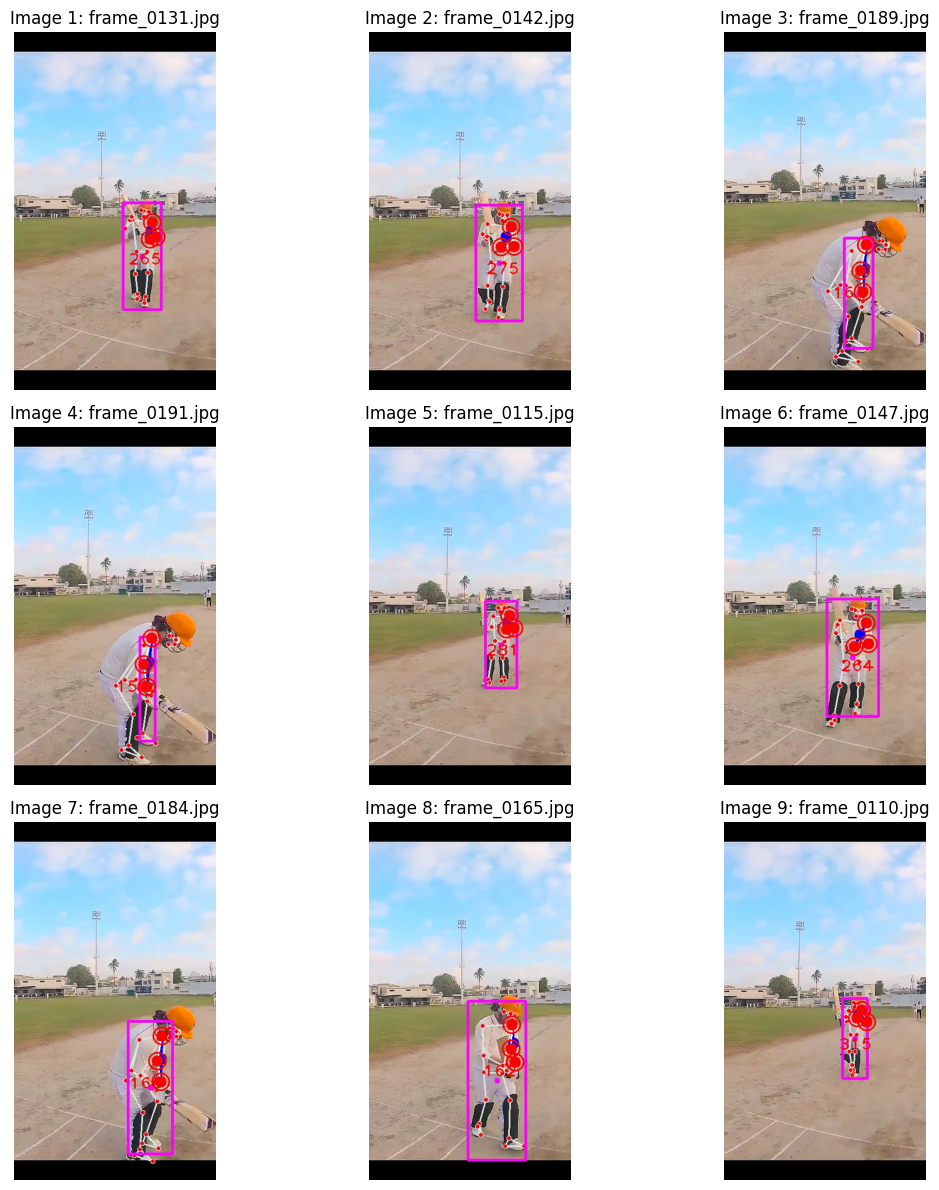

In [8]:
# Filter jpg_files to include only the first 100 images
jpg_files = [f for f in os.listdir(frame_dir) if f.lower().endswith('.jpg') and int(f.split('_')[1].split('.')[0]) > 100 and int(f.split('_')[1].split('.')[0]) < 200]

# Randomly sample 9 images from the filtered list
jpg_files = random.sample(jpg_files, 9)

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

for i, img_file in enumerate(jpg_files):
    img_path = os.path.join(frame_dir, img_file)
    try:
        img = plt.imread(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f"Image {i+1}: {img_file}")
        axes[i].axis('off')  # Hide axes
    except Exception as e:
        print(f"Error loading {img_file}: {e}")
        axes[i].text(0.5, 0.5, f"Error loading\n{img_file}", 
                    horizontalalignment='center',
                    verticalalignment='center')
        axes[i].axis('off')

for j in range(len(jpg_files), 9):
    axes[j].axis('off')

plt.tight_layout()
plt.show()